In [1]:
%load_ext tensorboard

# ConvXpress Model Evaluation (With Augmentation Layers)

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [3]:
class_names = ['Disturbed Galaxies', 'Merging Galaxies', 'Round Smooth Galaxies', 'In-between Round Smooth Galaxies', 'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 
              'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 'Edge-on Galaxies without Bulge', 'Edge-on Galaxies with Bulge']

## Helper Functions

In [4]:
def get_data_from_h5(filename):
    with h5py.File(filename, 'r') as f:
        # Get images
        images = np.array(f['images'])
        labels = np.array(f['ans'])
        
        # Convert labels to 10 categorical classes
        labels = tf.keras.utils.to_categorical(labels, 10)
    return images, labels

def get_test_data(test_idxs, dataset):
    test_idx = []
    with open(test_idxs) as f:
        for idx in f:
            test_idx.append(int(idx))
            
    images, labels = get_data_from_h5(dataset)
    images, labels = images[test_idx], labels[test_idx]
    images = images / 255
    with tf.device('cpu'):
        grey_images = tf.reduce_mean(input_tensor=images, axis=3, keepdims=True)
    
    return grey_images, labels

In [5]:
def get_learning_rate_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

## Loading Data

In [6]:
test_imgs, test_lbls = get_test_data('../test_idx.csv', '../Galaxy10_DECals.h5')

## Loading and Compiling Model

In [7]:
learning_rate = 1e-4
epochs = 1000
rnd_seed = 8901

optimizer = Adam(learning_rate=learning_rate)
learningRateMetric = get_learning_rate_metric(optimizer)
loss_function = CategoricalCrossentropy(from_logits=False)

model = load_model('../model_save/Galaxy10_convXpress_0.0001_1000_final.h5', compile=False)
model.compile(optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy',learningRateMetric])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 256, 256, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 1)       0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 224, 224, 1)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10)                3418950   
Total params: 3,418,950
Trainable params: 3,418,950
Non-trainable params: 0
_________________________________________________________________


## Model Evaluation

In [9]:
test_loss, test_acc, loss_rate = model.evaluate(test_imgs, test_lbls, verbose=1)

print('Test accuracy:', test_acc)

111/111 [==============================] - 12s 107ms/step - loss: 0.7156 - accuracy: 0.7627 - lr: 1.0000e-04
Test accuracy: 0.7626832127571106


## Making Predictions

In [10]:
predictions = model.predict(test_imgs,verbose=1)

111/111 [==============================] - 12s 104ms/step


## Analysing Model Predictions

In [11]:
y_hat = np.argmax(predictions, axis=1)
conv_labels = np.argmax(test_lbls, axis=1)
cm = confusion_matrix(conv_labels, y_hat)

print(accuracy_score(conv_labels, y_hat), '\n')

0.7626832018038332 



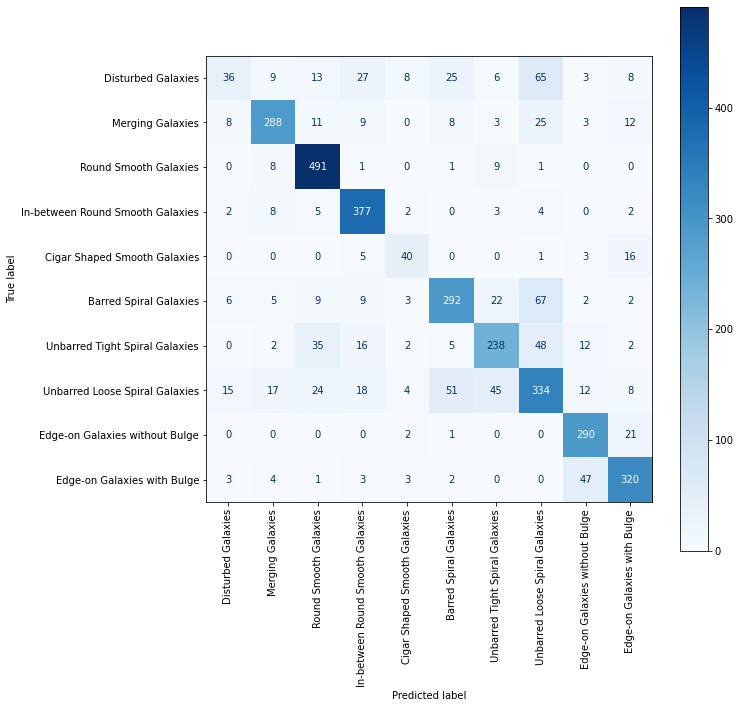

In [12]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1)

ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation='vertical', values_format='d', ax=ax)
plt.show()

In [13]:
print(classification_report(conv_labels, y_hat, target_names=class_names))

                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.51      0.18      0.27       200
                Merging Galaxies       0.84      0.78      0.81       367
           Round Smooth Galaxies       0.83      0.96      0.89       511
In-between Round Smooth Galaxies       0.81      0.94      0.87       403
    Cigar Shaped Smooth Galaxies       0.62      0.62      0.62        65
          Barred Spiral Galaxies       0.76      0.70      0.73       417
  Unbarred Tight Spiral Galaxies       0.73      0.66      0.69       360
  Unbarred Loose Spiral Galaxies       0.61      0.63      0.62       528
  Edge-on Galaxies without Bulge       0.78      0.92      0.85       314
     Edge-on Galaxies with Bulge       0.82      0.84      0.83       383

                        accuracy                           0.76      3548
                       macro avg       0.73      0.72      0.72      3548
                    weighted avg    

In [ ]:
%tensorboard --logdir '../logs/fit'